# Lives Saved Estimates with Python MINIMOD

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import pandas as pd
import minimod
from glob import glob
from pathlib import Path
import re
from functools import reduce

Using Python-MIP package version 1.7.3


In [3]:
# Folder with data
data_folder = Path('Optimization Work', 'demewoz_lives_saved','data_files')

## Processing Data

In [4]:
# get just the lives saved .xlsx files 
data_files = data_folder.glob(r'*Lives *')

In [5]:
list(data_files)

[PosixPath('Optimization Work/demewoz_lives_saved/data_files/APril22_VitaminA AND ZInc Combined Lives saved.xlsx'),
 PosixPath('Optimization Work/demewoz_lives_saved/data_files/APril22_Vitamin A alone Lives saved.xlsx')]

In [6]:
# Create dictionary for all files
all_dfs = {}

# Read in data
for d in data_files:
    df = pd.read_excel(d)
    all_dfs[d.stem] = df

In [7]:
# Now rename columns:
# - intervention
# - region
# Then set index to intervention and region, and stack time
final_dfs = []

for df in all_dfs:

    stacked_df = all_dfs[df].set_index()


### Using Justin's Data

Based on the call on May 20th, 2020, we load in the data and then make a few adjustments.

In [8]:
# First we load in the data

benefits_low = pd.read_excel(Path(data_folder, 'justin_data', "benefits_zincVAfolate_demwoaz.xlsx"), sheet_name='deathsaverted')

costs_low = pd.read_excel(Path(data_folder, 'justin_data', "benefits_zincVAfolate_demwoaz.xlsx"), sheet_name='deathsavertedcost')

benefits_high = pd.read_excel(Path(data_folder, 'justin_data', "benefits_zincVAfolate_demwoaz_high.xlsx"), sheet_name='deathsaverted')

costs_high = pd.read_excel(Path(data_folder, 'justin_data', "benefits_zincVAfolate_demwoaz_high.xlsx"), sheet_name='deathsavertedcost')

# Add Folate Benefits and costs

folate_costs = pd.read_excel(Path(data_folder, 'justin_data', "benefits_zincVAfolate_demwoaz.xlsx"), sheet_name='folate')

In [9]:
folate_costs

,Intervention,zoneName,NTD_saved_no_2020,NTD_saved_no_2021,NTD_saved_no_2022,NTD_saved_no_2023,NTD_saved_no_2024,NTD_saved_no_2025,NTD_saved_no_2026,NTD_saved_no_2027,NTD_saved_no_2028,NTD_saved_no_2029
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
2,flour,North,183.0,185.0,187.0,191.0,194.0,197.0,201.0,205.0,210.0,215.0
3,flour,South,284.0,286.0,287.0,289.0,290.0,290.0,292.0,292.0,293.0,293.0
4,flour,Cities,182.0,188.0,192.0,196.0,200.0,204.0,208.0,212.0,215.0,217.0
5,cube,North,297.0,299.0,303.0,309.0,315.0,320.0,325.0,332.0,340.0,348.0
6,cube,South,432.0,434.0,436.0,439.0,440.0,441.0,443.0,444.0,445.0,445.0
7,cube,Cities,183.0,188.0,193.0,197.0,200.0,204.0,209.0,212.0,215.0,217.0
8,cubeflour,North,304.0,306.0,310.0,317.0,322.0,327.0,333.0,340.0,348.0,356.0
9,cubeflour,South,456.0,458.0,460.0,463.0,464.0,466.0,468.0,469.0,470.0,469.0


In [10]:
year_to_num_dict = {k:v for k,v in zip(range(2020,2030), range(1,11))}

def process_data(data, name):

    df = (
        data
        .drop(0)
        .drop(1)
        .drop([2030, 2031,2032,2033,2034,2035], axis=1)
        .rename({'Vitamin A, Zinc interventions' : 'intervention',
        'Zone' : 'space'}, axis=1)
        .rename(year_to_num_dict, axis=1)
        .set_index(['intervention', 'space'])
        .stack()
        .reset_index()
        .rename({0 : name, 'level_2' : 'time'}, axis=1)
    )

    df['space'] = df['space'].str.lstrip().str.rstrip()

    return df

df_benefits_low = process_data(benefits_low, 'benefits_low')
df_costs_low = process_data(costs_low, 'costs_low')
df_benefits_high = process_data(benefits_high, 'benefits_high')
df_costs_high = process_data(costs_high, 'costs_high')

# Small sanity check to make sure we didn't do anything bad yet...

for i, data in enumerate([df_benefits_low, df_benefits_high, df_costs_low, df_costs_high]):

    N = len(data)

    time = data['time'].nunique()
    interventions = data['intervention'].nunique()
    space = data['space'].nunique()

    if interventions != 55:
        print(f"There are {interventions} interventions, not 55")
    
    if N != time*interventions*space:
        print(f"something is wrong with the {i}th frame. There are {N} observations, but {time*interventions*space} values")



In [11]:
# Merge together the files

df = reduce(lambda x,y: x.merge(y, on = ['intervention', 'space', 'time']), [df_benefits_low, df_benefits_high, df_costs_low, df_costs_high])

## Summary Statistics

Now we show some summary statistics of the data

In [12]:
s = minimod.utils.summary.PreOptimizationDataSummary(
    data = df,
    benefit_col= 'benefits_low',
    cost_col= 'costs_low',
    intervention_col='intervention',
    space_col= 'space',
    time_col='time',
    benefit_title='Lives Saved (Low)',
    intervention_subset=['zcube', 'flour', 'flourzcube', 'cube']
)

s.summary_table(variables_of_interest= {'Cost per Child' : 'cost_per_benefit'}, grouping = 'over_space', style = 'markdown')


,Regions,Intervention,Lives Saved (Low),Costs,Cost per Child
0,Cities,cube,"1,699","$846,561",498.21
1,Cities,flour,"3,892","$4,115,234",1057.43
2,Cities,flourzcube,"4,721","$4,664,117",987.85
3,Cities,zcube,0,"$548,883",inf
4,National,cube,"11,898","$3,638,796",305.82
5,National,flour,"10,620","$10,540,722",992.53
6,National,flourzcube,"13,955","$12,900,001",924.39
7,National,zcube,0,"$2,359,279",inf
8,North,cube,"6,179","$1,329,522",215.15
9,North,flour,"3,371","$2,489,185",738.44


## Run MINIMOD

In [27]:
m = minimod.Minimod(data = df, solver_type = 'costmin', benefit_col = 'benefits_low', cost_col = 'costs_low', minimum_benefit = 'oilvas')

[Note]: Processing Data...
[Note]: Creating Base Model with constraints


AttributeError: 'CostSolver' object has no attribute 'minimum_benefit'

In [37]:
m.fit(data = df,
    all_space = ['cube', 'oil', 'flour'], 
    all_time = ['oil', 'cube'],
    time_subset = [1,2,3],
    costs = 'costs_low',
    benefits = 'benefits_low',
    benefit_title = 'Lives Saved')

[Note]: Processing Data...
[Note]: Creating Base Model with constraints
[Note]: Optimizing...
[Note]: Optimal Solution Found


In [38]:
m.report()

+----------------------------+----------------------------+
| MiniMod Solver Results     |                            |
| Method:                    | MIN                        |
| Solver:                    | CBC                        |
| Optimization Status:       | OptimizationStatus.OPTIMAL |
| Number of Solutions Found: | 1                          |
+----------------------------+----------------------------+
+-----------------------------+--------+
| No. of Variables:           |   6600 |
| No. of Integer Variables:   |   6600 |
| No. of Constraints          |  50500 |
| No. of Non-zeros in Constr. | 113832 |
+-----------------------------+--------+
+------------------+--------------------+
| Minimum Benefit  | oilvasflour        |
| Total Cost       | 20020623.442919627 |
| TotalLives Saved | 19245620.092023775 |
+------------------+--------------------+
+------------------+---------+
| Cost per Benefit | 0.96129 |
+------------------+---------+
+------------------------------

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f352ab96af0>)

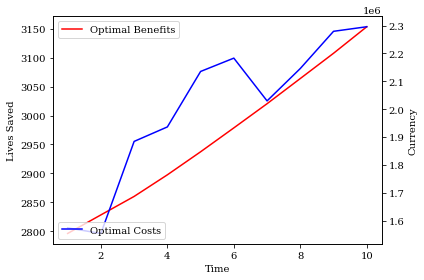

In [39]:
m.plot_time()